<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Masked_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.models as tfkm
import tensorflow.keras.layers as tfkl
import tensorflow.keras.utils as tfku

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.cifar100.load_data()

In [4]:
class ClassificationTransformer(tfkm.Model):
    def __init__(self, **kwds):
        inp_context_len = kwds['inp_context_len']
        out_context_len = kwds['out_context_len']
        inp_num_tokens = kwds['inp_num_tokens']
        out_num_tokens = kwds['inp_num_tokens']
        encoding_len = kwds['encoding_len']
        ff_hidden = kwds['ff_hidden']
        num_encoders = kwds['num_encoders']
        num_decoders = kwds['num_decoders']
        num_heads = kwds['num_heads']
        key_dim = kwds['key_dim']
        max_pos_idx = kwds['max_pos_idx']
        pos_enc_arr = kwds['pos_enc']

        inp = tfkl.Input([inp_context_len])
        inp_pos = tfkl.Input([inp_context_len])

        out = tfkl.Input([out_context_len])
        out_pos = tfkl.Input([out_context_len])

        in_position_encoding = tfkl.Embedding(input_dim = max_pos_idx, output_dim = encoding_len)
        in_position_encoding.trainable = False

        out_position_encoding = tfkl.Embedding(input_dim = max_pos_idx, output_dim = encoding_len)
        out_position_encoding.trainable = False

        inp_pos_enc = in_position_encoding(inp_pos)
        out_pos_enc = out_position_encoding(out_pos)

        in_position_encoding.set_weights([pos_enc_arr])
        out_position_encoding.set_weights([pos_enc_arr])

        x = inp
        x = tfkl.Embedding(input_dim = inp_num_tokens, output_dim = encoding_len)(x)
        x = tfkl.Add()([x, inp_pos_enc])

        #encoder block

        for _ in range(num_encoders):
            #self attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim)(x, x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #feed forward
            res = x
            x = tfkl.Dense(ff_hidden)(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(encoding_len)(x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

        encoding = x

        #decoder block

        x = out
        x = tfkl.Embedding(input_dim = out_num_tokens, output_dim = encoding_len)(x)
        x = tfkl.Add()([x, out_pos_enc])

        for _ in range(num_decoders):
            #self attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim)(x, x, use_causal_mask = True)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #cross attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim)(x, encoding)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #feed forward
            res = x
            x = tfkl.Dense(ff_hidden)(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(encoding_len)(x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)


        pred = tfkl.Dense(out_num_tokens)(x)

        super(ClassificationTransformer, self).__init__(inputs = [inp, inp_pos, out, out_pos], outputs = [pred])

In [5]:
class RegressionTransformer(tfkm.Model):
    def __init__(self, **kwds):
        inp_context_len = kwds['inp_context_len']
        out_context_len = kwds['out_context_len']
        num_input = kwds['num_input']
        num_output = kwds['num_output']
        encoding_len = kwds['encoding_len']
        ff_hidden = kwds['ff_hidden']
        num_encoders = kwds['num_encoders']
        num_decoders = kwds['num_decoders']
        num_heads = kwds['num_heads']
        key_dim = kwds['key_dim']
        max_pos_idx = kwds['max_pos_idx']
        pos_enc_arr = kwds['pos_enc']

        inp = tfkl.Input([inp_context_len, num_input])
        inp_pos = tfkl.Input([inp_context_len])

        out = tfkl.Input([out_context_len, num_output])
        out_pos = tfkl.Input([out_context_len])

        in_position_encoding = tfkl.Embedding(input_dim = max_pos_idx, output_dim = encoding_len)
        in_position_encoding.trainable = False

        out_position_encoding = tfkl.Embedding(input_dim = max_pos_idx, output_dim = encoding_len)
        out_position_encoding.trainable = False

        inp_pos_enc = in_position_encoding(inp_pos)
        out_pos_enc = out_position_encoding(out_pos)

        in_position_encoding.set_weights([pos_enc_arr])
        out_position_encoding.set_weights([pos_enc_arr])

        x = inp
        x = tfkl.Dense(encoding_len)(x)
        x = tfkl.Add()([x, inp_pos_enc])

        #encoder block

        for _ in range(num_encoders):
            #self attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim)(x, x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #feed forward
            res = x
            x = tfkl.Dense(ff_hidden)(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(encoding_len)(x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

        encoding = x

        #decoder block

        x = out
        x = tfkl.Dense(encoding_len)(x)
        x = tfkl.Add()([x, out_pos_enc])

        for _ in range(num_decoders):
            #self attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim)(x, x, use_causal_mask = True)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #cross attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim)(x, encoding)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #feed forward
            res = x
            x = tfkl.Dense(ff_hidden)(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(encoding_len)(x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)


        x = tfkl.Dense(num_output)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.Activation('tanh')(x)
        pred = x

        super(RegressionTransformer, self).__init__(inputs = [inp, inp_pos, out, out_pos], outputs = [pred])

In [6]:
def get_position_encoding(num):
    pos_enc_df = pd.DataFrame({'t': np.arange(2**num)})

    for idx in range(num):
        pos_enc_df.eval(f's{idx} = sin({2 ** idx} * {np.pi/2} * t / {2 ** num})', inplace = True)
        pos_enc_df.eval(f'c{idx} = cos({2 ** idx} * {np.pi/2} * t / {2 ** num})', inplace = True)

    pos_enc_df.drop('t', axis = 1, inplace = True)

    return pos_enc_df.values

In [7]:
pos_enc = get_position_encoding(11)

In [8]:
pos_enc.shape

(2048, 22)

<Axes: >

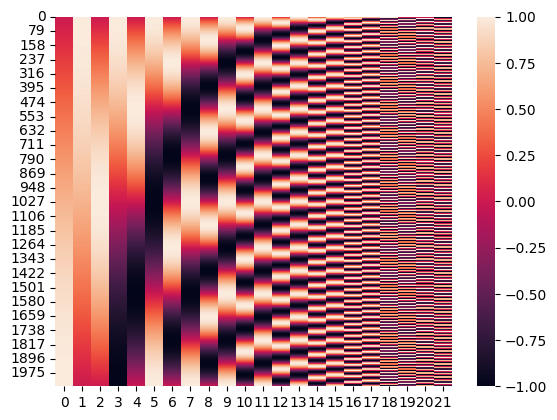

In [9]:
sns.heatmap(pos_enc)

In [10]:
model = RegressionTransformer(
    inp_context_len = 1024,
    out_context_len = 1024,
    num_input = 3,
    num_output = 3,
    encoding_len = 22,
    ff_hidden = 8,
    num_encoders = 8,
    num_decoders = 4,
    num_heads = 3,
    key_dim = 2,
    max_pos_idx = 2048,
    pos_enc = pos_enc
)

In [11]:
model.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.MeanSquaredError()
)

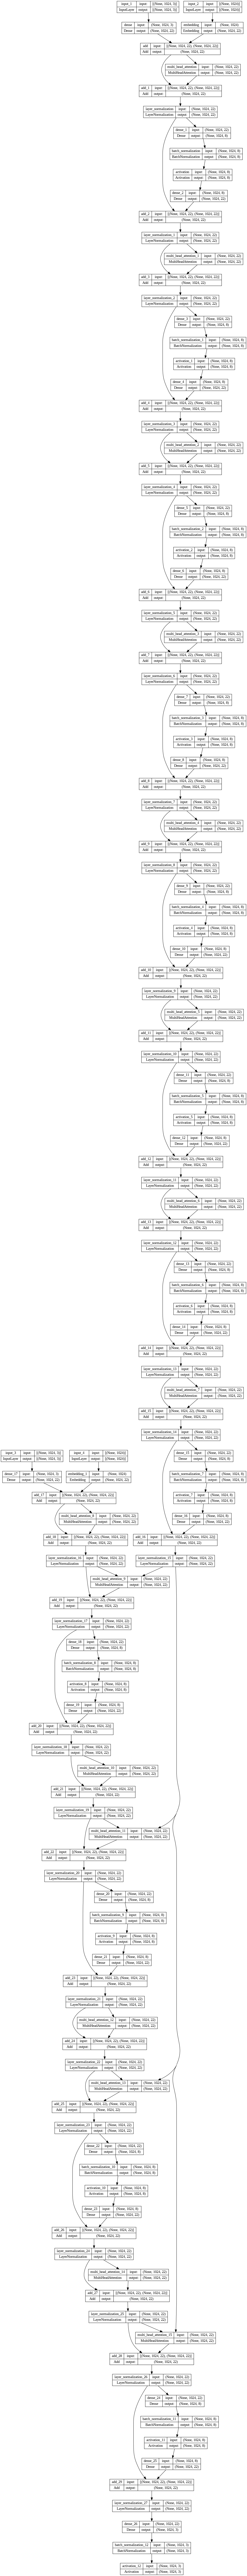

In [12]:
tfku.plot_model(model, show_shapes = True)

In [13]:
model.summary()

Model: "regression_transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 3)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1024)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 1024, 22)             88        ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1024, 22)             45056     ['input_2[0][0]']             
                                                                             

In [14]:
def preprocess_input(x):
    input_shape = tf.shape(x)
    new_size = input_shape[-3] * input_shape[-2]
    flatten_x =  tf.reshape(x, [new_size, input_shape[-1]])
    norm_flatten_x = tf.cast(flatten_x, dtype = tf.float32)/127.5 - 1

    return norm_flatten_x

In [15]:
@tf.function
def train_fn(x):
    dataset = (
        tf.data.Dataset.from_tensor_slices(x)
                      .map(preprocess_input)
                      .batch(8)
    )

    for batch_idx, batch_x in enumerate(dataset):
        input_shape = tf.shape(batch_x)
        inp_pos = tf.range(input_shape[1])[tf.newaxis, ...]

        start_offset = tf.zeros([input_shape[0], 1, input_shape[2]], dtype = batch_x.dtype)
        offset_input = tf.concat([start_offset, batch_x[:, :-1, :]], axis = 1)

        out_pos = tf.range(input_shape[1])[tf.newaxis, ...]

        mask = tf.floor(2.0 * tf.random.uniform(input_shape[:2]))[..., tf.newaxis]
        masked_input = mask * batch_x

        vars = model.trainable_weights

        with tf.GradientTape() as tape:
            pred = model([masked_input, inp_pos, offset_input, out_pos])
            loss = model.compute_loss(y_pred = pred, y = batch_x)

        model.optimizer.minimize(loss, vars, tape)

        tf.print(loss)


In [ ]:
train_fn(x_train)

0.773191929
0.703230917
0.530485809
0.599428177
0.527960241
0.501315
0.460050106
0.441404343
0.438540041
0.366770864
0.382052481
0.365197122
0.348718703
0.30664438
0.28841567
0.301017851
0.272109568
0.220588595
0.237528414
0.19497636
0.193762124
0.203954369
0.179528505
0.193525925
0.187068582
0.213546917
0.162294492
0.160099566
0.16707918
0.193513662
0.173682138
0.199891984
0.154060662
0.123266533
0.150261506
0.17056258
0.163857684
0.157181203
0.158463269
0.157081008
0.165073738
0.115144625
0.125006199
0.116872244
0.110110678
0.141647965
0.111952506
0.109621592
0.125895336
0.121570617
0.124313757
0.147561193
0.123186961
0.121556103
0.125108615
0.104293838
0.106890798
0.141896755
0.106243923
0.103558347
0.103061303
0.131357953
0.115302026
0.119787611
